# Merging LSTM and CovNet

In [6]:
import numpy as np

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, LSTM, Input, Dense
from keras.layers.merge import concatenate
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
import matplotlib.pyplot as plt

Get LSTM data

In [4]:
# train data
qcd_train = np.load('LSTM_dataset/train/QCD_ptJ_mj_mmdt_dkTlead_0001.npz')
tt_train  = np.load('LSTM_dataset/train/tt_ptJ_mj_mmdt_dkTlead_0061.npz')
X_LSTM    = np.vstack((tt_train['sample'],qcd_train['sample']))
X_LSTM    = X_LSTM.reshape(X_LSTM.shape[0],X_LSTM.shape[1],1)

y_LSTM = []
y_LSTM.extend([1]*10000)
y_LSTM.extend([0]*10000)

# validation data
qcd_val    = np.load('LSTM_dataset/val/QCD_ptJ_mj_mmdt_dkTlead_0001.npz')
tt_val     = np.load('LSTM_dataset/val/tt_ptJ_mj_mmdt_dkTlead_0021.npz')

X_val_LSTM = np.vstack((tt_val['sample'],qcd_val['sample']))
X_val_LSTM = X_val_LSTM.reshape(X_val_LSTM.shape[0],X_val_LSTM.shape[1],1)

y_val_LSTM = []
y_val_LSTM.extend([1]*10000)
y_val_LSTM.extend([0]*10000)

assert len(y_val_LSTM) == len(X_val_LSTM)
assert len(y_LSTM) == len(X_LSTM)

Get CovNet data

In [5]:
# train data
path = '/mt/batch/jaraz/RNN_CNN/ANALYSIS_1/images2/'
qcd      = np.load(path+'train/QCD_train_001_10000_norm.npz')
tt       = np.load(path+'train/tt_train_001_10000_norm.npz')
X_CovNet = np.vstack((tt['image'],qcd['image']))
X_CovNet = X_CovNet.reshape(20000,37,37,1)

y_CovNet = []
y_CovNet.extend([1]*10000)
y_CovNet.extend([0]*10000)

# validation data
qcd_val = np.load(path+'val/QCD_val_001_10000_norm.npz')
tt_val  = np.load(path+'val/tt_val_001_10000_norm.npz')
X_val_CovNet  = np.vstack((tt_val['image'],qcd_val['image']))
X_val_CovNet  = X_val_CovNet.reshape(20000,37,37,1)

y_val_CovNet = []
y_val_CovNet.extend([1]*10000)
y_val_CovNet.extend([0]*10000)

assert len(y_val_CovNet) == len(X_val_CovNet)
assert len(y_CovNet) == len(X_CovNet)

# Neural Network Setup

In [8]:
# CovNet
cov_input    = Input(shape=(37,37,1))
cov_hidden   = Conv2D(8, (4, 4), activation='relu',padding='same')(cov_input)
cov_hidden   = Conv2D(8, (4, 4), activation='relu',padding='same')(cov_hidden)
cov_hidden   = MaxPooling2D(pool_size=(2, 2))(cov_hidden)
cov_hidden   = Conv2D(8, (4, 4), activation='relu',padding='same')(cov_hidden)
cov_hidden   = Conv2D(8, (4, 4), activation='relu',padding='same')(cov_hidden)
cov_hidden   = Flatten()(cov_hidden)
cov_hidden   = Dense(64, activation='relu')(cov_hidden)
cov_hidden   = Dense(64, activation='relu')(cov_hidden)
cov_hidden   = Dense(64, activation='relu')(cov_hidden)
cov_output   = Dense(1, activation='sigmoid')(cov_hidden)
CovNet_model = Model(inputs=cov_input, outputs=cov_output)


# LSTM
lstm_input = Input(shape=(X_val_LSTM.shape[1],1))
lstm_hidden = LSTM(10, activation="tanh", 
                   recurrent_activation='hard_sigmoid')(lstm_input)
lstm_hidden = Dropout(0.25)(lstm_hidden)
lstm_output = Dense(1, activation='sigmoid')(lstm_hidden)
LSTM_model  = Model(inputs=lstm_input, outputs=lstm_output)

# Merge
merged_output = concatenate([CovNet_model.output, LSTM_model.output], axis=-1)
merged_model  = Dense(1, activation='sigmoid')(merged_output)

model = Model(inputs=[CovNet_model.input, LSTM_model.input], outputs=merged_model)

model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 37, 37, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 37, 37, 8)    136         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 37, 37, 8)    1032        conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 18, 18, 8)    0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [10]:
batch_size = 128
n_epochs = 50

history = model.fit([X_CovNet,X_LSTM], np.array(y_CovNet), 
                    epochs=n_epochs, 
                    batch_size=batch_size, 
                    verbose = 1,
                    validation_data=([X_val_CovNet,X_val_LSTM], np.array(y_val_CovNet)),
                    callbacks = [
                    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                    TerminateOnNaN()])

Train on 20000 samples, validate on 20000 samples
Epoch 1/50
20000/20000 [==============================] - 10s 508us/step - loss: 0.6726 - accuracy: 0.6926 - val_loss: 0.6458 - val_accuracy: 0.8703
Epoch 2/50
20000/20000 [==============================] - 8s 409us/step - loss: 0.6079 - accuracy: 0.8488 - val_loss: 0.5582 - val_accuracy: 0.8085
Epoch 3/50
20000/20000 [==============================] - 8s 415us/step - loss: 0.5249 - accuracy: 0.8140 - val_loss: 0.4916 - val_accuracy: 0.8289
Epoch 4/50
20000/20000 [==============================] - 8s 396us/step - loss: 0.4770 - accuracy: 0.8273 - val_loss: 0.4710 - val_accuracy: 0.8037
Epoch 5/50
20000/20000 [==============================] - 7s 372us/step - loss: 0.4551 - accuracy: 0.8120 - val_loss: 0.4470 - val_accuracy: 0.8059
Epoch 6/50
20000/20000 [==============================] - 7s 371us/step - loss: 0.4240 - accuracy: 0.8332 - val_loss: 0.4046 - val_accuracy: 0.8592
Epoch 7/50
20000/20000 [==============================] - 8s 

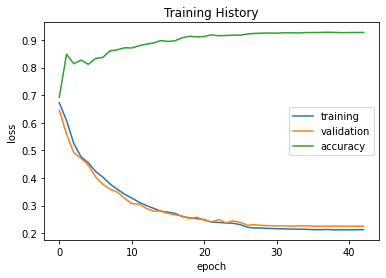

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
#plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation','accuracy'], loc='best')
plt.show()

In [14]:
# test data
qcd_test    = np.load('LSTM_dataset/test/QCD_ptJ_mj_mmdt_dkTlead_0001.npz')
tt_test     = np.load('LSTM_dataset/test/tt_ptJ_mj_mmdt_dkTlead_0021.npz')

X_test_LSTM = np.vstack((tt_test['sample'],qcd_test['sample']))
X_test_LSTM = X_val_LSTM.reshape(X_test_LSTM.shape[0],X_test_LSTM.shape[1],1)

y_test_LSTM = []
y_test_LSTM.extend([1]*10000)
y_test_LSTM.extend([0]*10000)

path = '/mt/batch/jaraz/RNN_CNN/ANALYSIS_1/images2/'
qcd_test       = np.load(path+'test/QCD_test_001_10000_norm.npz')
tt_test        = np.load(path+'test/tt_test_001_10000_norm.npz')
X_test_CovNet  = np.vstack((tt_test['image'],qcd_test['image']))
X_test_CovNet  = X_CovNet.reshape(20000,37,37,1)

y_test_CovNet  = []
y_test_CovNet.extend([1]*10000)
y_test_CovNet.extend([0]*10000)

assert len(y_test_LSTM) == len(X_test_LSTM)
assert len(X_test_CovNet) == len(y_test_CovNet)

In [15]:
yhat = model.predict([X_test_CovNet,X_test_LSTM], verbose = True)

20000/20000 [==============================] - 5s 248us/step


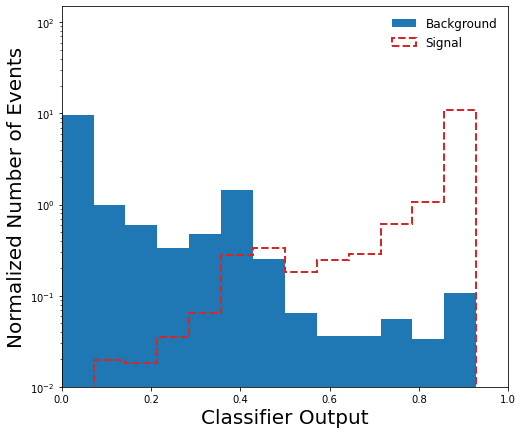

In [17]:
fig = plt.figure(figsize=(8, 7), facecolor='w', edgecolor='k')
# sys1 = fig.add_subplot()
binss = np.linspace(0,1,15)
bkg = plt.hist(yhat[np.array(y_test_CovNet) != 1],
         histtype='bar',  bins=binss, 
         label=r'Background',density=True,
         linewidth=0, color='tab:blue', linestyle='solid')
sig = plt.hist(yhat[np.array(y_test_CovNet) == 1],
         histtype='step', bins=binss, 
         label=r'Signal',
         color=None, edgecolor='tab:red', linewidth=2, linestyle="dashed",
         bottom=None, cumulative=False, density=True, align="mid", orientation="vertical")
leg = plt.legend(loc='upper right',fontsize=12)
leg.get_frame().set_alpha(0.5)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
# plt.xaxis.set_major_locator(MultipleLocator(0.2))
# plt.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.xaxis.set_minor_locator(MultipleLocator(0.2/5.))
plt.xlabel('Classifier Output',fontsize=20)
plt.ylabel('Normalized Number of Events',fontsize=20)
plt.axis([0,1,1e-2,150])
plt.yscale("log", nonposy='clip')
plt.show()

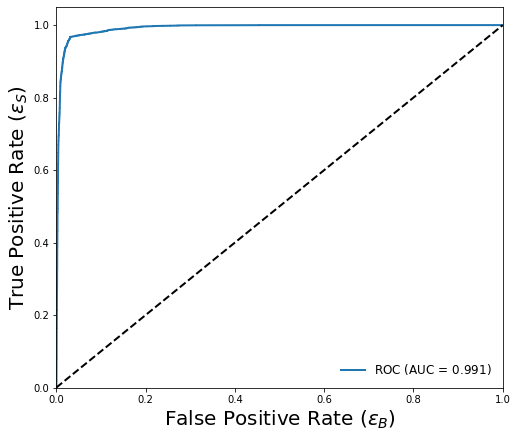

In [18]:
from sklearn.metrics import roc_curve, auc
## Plot ROC
# Signal labal is 0 
fpr, tpr, tresholds = roc_curve(y_test_CovNet, yhat,pos_label=1, 
                                drop_intermediate=False)
# fpr, tpr, tresholds = roc_curve(y_test, yhat[:,0])
roc_auc = auc(fpr, tpr)

fig = plt.figure(figsize=(8, 7), facecolor='w', edgecolor='k')
# sys2 = fig.add_subplot()

# sys2.plot(tpr, 1./fpr,color='tab:blue',lw=2,
#           label=r'ROC (AUC = ${:.3f}$)'.format(roc_auc))
plt.plot(fpr, tpr,color='tab:blue',lw=2,
          label=r'ROC (AUC = ${:.3f}$)'.format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.axis([0,1,0,1.05])
# sys2.set_xlim((0, 1))
# sys2.set_ylim((1, 1000))
# sys2.set_yscale('log')
plt.xlabel('False Positive Rate ($\epsilon_B$)',fontsize=20)
plt.ylabel('True Positive Rate ($\epsilon_S$)',fontsize=20)
# plt.xaxis.set_major_locator(MultipleLocator(.2))
# plt.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.xaxis.set_minor_locator(MultipleLocator(.2/5.))
# plt.yaxis.set_major_locator(MultipleLocator(.2))
# plt.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# plt.yaxis.set_minor_locator(MultipleLocator(.2/5.))
leg = plt.legend(loc='best',fontsize=12)
leg.get_frame().set_alpha(0.5)
leg.get_frame().set_linewidth(0.0)
leg.set_zorder(100)
#plt.savefig(os.path.join(path,'roc_curve.png'),bbox_inches='tight')
plt.show()